### Imports and Configurations

In [1]:
# Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import optuna
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, cross_val_score

from sklearn.metrics import (
    accuracy_score, 
    confusion_matrix, 
    classification_report, 
    roc_auc_score, 
    roc_curve,
    precision_recall_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import uniform, randint

# Configurations
%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings('ignore') 

print("Libraries imported successfully.")

/Users/sleepdeprived/miniforge3/envs/LLM/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Libraries imported successfully.


### Loading the Data

In [2]:
input_filename = 'cleaned_student_data.csv' 

df_model = pd.read_csv(input_filename)
print(f"\nLoaded data from '{input_filename}'. Shape: {df_model.shape}")

# Quick verification:
print("\nVerifying column types:\n")
print(df_model.info())

# Checking if 'Depression' column exists
if 'Depression' not in df_model.columns:
    raise ValueError("Target column 'Depression' not found in the loaded data.")


Loaded data from 'cleaned_student_data.csv'. Shape: (27851, 91)

Verifying column types:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27851 entries, 0 to 27850
Data columns (total 91 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   Age                                        27851 non-null  float64
 1   Academic Pressure                          27851 non-null  float64
 2   CGPA                                       27851 non-null  float64
 3   Study Satisfaction                         27851 non-null  float64
 4   Suicidal_Thoughts                          27851 non-null  int64  
 5   Work/Study Hours                           27851 non-null  float64
 6   Financial Stress                           27851 non-null  float64
 7   Family History of Mental Illness           27851 non-null  int64  
 8   Depression                                 27851 non-null  int64  
 9   Sle

### Separating Features (X) and Target (y)

In [3]:
target_column = 'Depression'
y = df_model[target_column]
X = df_model.drop(columns=[target_column])

print(f"\nFeatures (X) shape: {X.shape}")
print(f"Target (y) shape: {y.shape}")

print("\nFeature columns used for training:\n")
print(list(X.columns))



Features (X) shape: (27851, 90)
Target (y) shape: (27851,)

Feature columns used for training:

['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Suicidal_Thoughts', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Sleep_Ordinal', 'Total_Stress', 'Gender_Male', 'City_Ahmedabad', 'City_Bangalore', 'City_Bhopal', 'City_Chennai', 'City_Delhi', 'City_Faridabad', 'City_Ghaziabad', 'City_Hyderabad', 'City_Indore', 'City_Jaipur', 'City_Kalyan', 'City_Kanpur', 'City_Kolkata', 'City_Lucknow', 'City_Ludhiana', 'City_Meerut', 'City_Mumbai', 'City_Nagpur', 'City_Nashik', 'City_Patna', 'City_Pune', 'City_Rajkot', 'City_Srinagar', 'City_Surat', 'City_Thane', 'City_Vadodara', 'City_Varanasi', 'City_Vasai-Virar', 'City_Visakhapatnam', 'Dietary Habits_Moderate', 'Dietary Habits_Others', 'Dietary Habits_Unhealthy', 'Degree_B.Com', 'Degree_B.Ed', 'Degree_B.Pharm', 'Degree_B.Tech', 'Degree_BA', 'Degree_BBA', 'Degree_BCA', 'Degree_BE', 'Degree_BHM', 'Degree_BSc', 'Deg

### Checking Class Balance

In [4]:
print("\nTarget Variable Distribution\n")
class_counts = y.value_counts(normalize=True) * 100
print(class_counts)

# Calculating scale_pos_weight for potential use if classes are imbalanced

count_neg = y.value_counts()[0]
count_pos = y.value_counts()[1]

# Handle potential division by zero 
scale_pos_weight_value = 1 
if count_pos > 0:
    scale_pos_weight_value = count_neg / count_pos
print(f"\nCalculated scale_pos_weight: {scale_pos_weight_value:.2f}")



Target Variable Distribution

Depression
1    58.575994
0    41.424006
Name: proportion, dtype: float64

Calculated scale_pos_weight: 0.71


### Splitting Data into Training and Testing Sets

In [5]:
# Using stratify=y to maintain class proportions in train/test splits

test_set_size = 0.2
random_seed = 42   

X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=test_set_size, 
    random_state=random_seed, 
    stratify=y  
)

print(f"Training set shape: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set shape: X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nTraining set target distribution:\n{y_train.value_counts(normalize=True) * 100}")
print(f"\nTesting set target distribution:\n{y_test.value_counts(normalize=True) * 100}")

Training set shape: X_train=(22280, 90), y_train=(22280,)
Testing set shape: X_test=(5571, 90), y_test=(5571,)

Training set target distribution:
Depression
1    58.577199
0    41.422801
Name: proportion, dtype: float64

Testing set target distribution:
Depression
1    58.571172
0    41.428828
Name: proportion, dtype: float64


### Initialize and Train XGBoost Model

In [6]:
def objective(trial):
    """Optuna objective function to minimize/maximize."""
    
    # Define hyperparameters to search using trial.suggest_* methods
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # Metric for XGBoost internal evaluation and early stopping
        'booster': 'gbtree',
        'n_estimators': trial.suggest_int('n_estimators', 100, 1000, step=50), # Explore # of trees
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True), # Explore learning rate on log scale
        'max_depth': trial.suggest_int('max_depth', 3, 10), # Explore tree depth
        'subsample': trial.suggest_float('subsample', 0.6, 1.0, step=0.05), # Explore subsample ratio
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0, step=0.05), # Explore feature sampling
        'gamma': trial.suggest_float('gamma', 0.0, 0.5, step=0.05), # Explore gamma
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10), # Explore min child weight
        'lambda': trial.suggest_float('lambda', 1e-3, 1.0, log=True), # L2 regularization
        'alpha': trial.suggest_float('alpha', 1e-3, 1.0, log=True),   # L1 regularization
        'random_state': 42, # Keep random state fixed for reproducibility within XGBoost
        # 'scale_pos_weight': scale_pos_weight_value # Include if imbalance is significant
        # Note: Removed use_label_encoder=False as it causes warnings
    }
    
    # Initialize XGBoost classifier with suggested parameters
    model = xgb.XGBClassifier(**params)
    
    # Define cross-validation strategy
    # Using the same StratifiedKFold ensures consistency if comparing methods
    n_splits_cv = 5
    cv_strategy = StratifiedKFold(n_splits=n_splits_cv, shuffle=True, random_state=42)
    
    # Perform cross-validation and get the average score
    # Use roc_auc as the scoring metric for optimization
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=cv_strategy, n_jobs=-1)
    
    # Return the mean score (Optuna maximizes this by default)
    return score.mean()

In [7]:
# --- 2. Create and Run the Optuna Study ---
n_trials = 50  # Number of optimization trials to run. Increase for more exploration.
study_name = 'xgboost-hyperopt' 

print(f"\n--- Starting Optuna Optimization ({n_trials} trials, optimizing ROC AUC) ---")

# Create the study object. 'direction="maximize"' means Optuna tries to find params 
# that yield the highest score returned by the objective function.
study = optuna.create_study(direction="maximize", study_name=study_name)

# Start the optimization process
# Optuna will call the 'objective' function n_trials times
study.optimize(objective, n_trials=n_trials, timeout=600) # Optional: Add timeout in seconds

print("\n--- Optuna Optimization Complete ---")


# --- 3. Get Best Results from Optuna ---
print(f"\nNumber of finished trials: {len(study.trials)}")
print(f"Best trial number: {study.best_trial.number}")
print(f"Best ROC AUC (CV on Train Set): {study.best_value:.4f}")

print("\nBest Parameters found:")
best_params = study.best_params
print(best_params)

[I 2025-05-05 11:01:21,727] A new study created in memory with name: xgboost-hyperopt



--- Starting Optuna Optimization (50 trials, optimizing ROC AUC) ---


[I 2025-05-05 11:01:24,008] Trial 0 finished with value: 0.9115000301280896 and parameters: {'n_estimators': 400, 'learning_rate': 0.05990779251544569, 'max_depth': 10, 'subsample': 0.85, 'colsample_bytree': 0.8, 'gamma': 0.30000000000000004, 'min_child_weight': 1, 'lambda': 0.13404080224012072, 'alpha': 0.0010627392402079129}. Best is trial 0 with value: 0.9115000301280896.
[I 2025-05-05 11:01:25,253] Trial 1 finished with value: 0.9163769698383115 and parameters: {'n_estimators': 250, 'learning_rate': 0.015534683601063868, 'max_depth': 3, 'subsample': 0.95, 'colsample_bytree': 0.8, 'gamma': 0.35000000000000003, 'min_child_weight': 1, 'lambda': 0.008916110658292026, 'alpha': 0.12496406973948056}. Best is trial 1 with value: 0.9163769698383115.
[I 2025-05-05 11:01:28,005] Trial 2 finished with value: 0.9043855437164346 and parameters: {'n_estimators': 1000, 'learning_rate': 0.12731894649942668, 'max_depth': 6, 'subsample': 0.95, 'colsample_bytree': 0.6, 'gamma': 0.0, 'min_child_weight'


--- Optuna Optimization Complete ---

Number of finished trials: 50
Best trial number: 42
Best ROC AUC (CV on Train Set): 0.9217

Best Parameters found:
{'n_estimators': 900, 'learning_rate': 0.013141479245336507, 'max_depth': 3, 'subsample': 0.6, 'colsample_bytree': 0.6, 'gamma': 0.45, 'min_child_weight': 7, 'lambda': 0.0033252061269713985, 'alpha': 0.001539098015024012}


In [8]:
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    random_state=42,
    **best_params # Use the best parameters found during tuning
)


--- Starting RFECV (cv=5, scoring='roc_auc') ---
This may take some time...
Fitting estimator with 90 features.
Fitting estimator with 89 features.
Fitting estimator with 88 features.
Fitting estimator with 87 features.
Fitting estimator with 86 features.
Fitting estimator with 85 features.
Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 

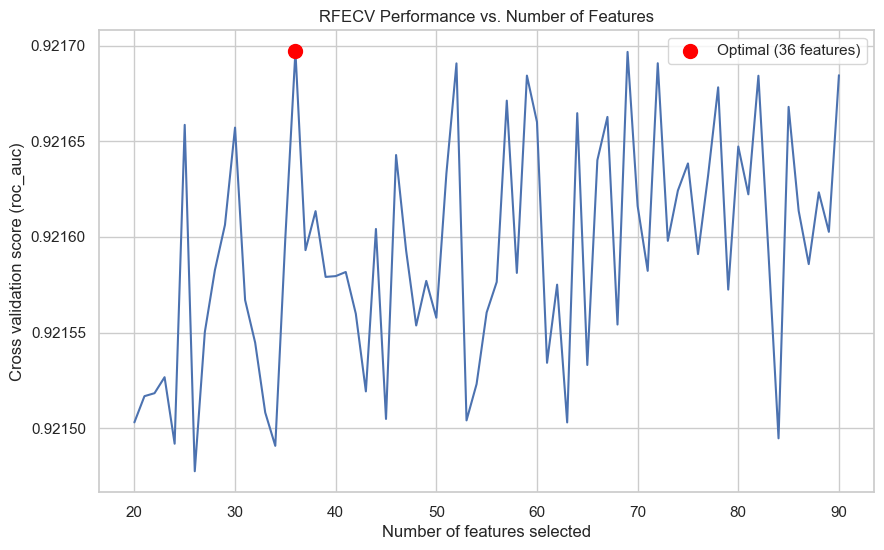


Selected Features (36):
['Age', 'Academic Pressure', 'CGPA', 'Study Satisfaction', 'Suicidal_Thoughts', 'Work/Study Hours', 'Financial Stress', 'Family History of Mental Illness', 'Sleep_Ordinal', 'Total_Stress', 'City_Ahmedabad', 'City_Chennai', 'City_Hyderabad', 'City_Jaipur', 'City_Meerut', 'City_Mumbai', 'City_Nagpur', 'City_Pune', 'Dietary Habits_Moderate', 'Dietary Habits_Unhealthy', 'Degree_B.Ed', 'Degree_B.Pharm', 'Degree_BA', 'Degree_BE', 'Degree_BHM', 'Degree_Class 12', 'Degree_LLM', 'Degree_MA', 'Degree_MD', 'Degree_MSc', 'Age_Group_25-30', 'Age_Group_31-39', 'Region_Eastern', 'Region_Northern', 'Degree_Field_General/Other', 'Degree_Field_Law']

Transformed training data shape: (22280, 36)
Transformed test data shape: (5571, 36)


In [9]:
# Setting up Cross-Validation for RFECV
n_splits_rfecv = 5  
cv_strategy_rfecv = StratifiedKFold(n_splits=n_splits_rfecv, shuffle=True, random_state=42)

# Initializing RFECV 

scoring_metric_rfecv = 'roc_auc' # Optimize for AUC during feature selection

print(f"\n--- Starting RFECV (cv={n_splits_rfecv}, scoring='{scoring_metric_rfecv}') ---")
print("This may take some time...")

rfecv = RFECV(
    estimator=best_xgb_model,    
    step=1,                      # Remove 1 feature per iteration
    cv=cv_strategy_rfecv,        
    scoring=scoring_metric_rfecv,
    min_features_to_select=20,   
    n_jobs=-1,                   # Use all available CPU cores
    verbose=1                    
)

# Fitting RFECV on Training Data
rfecv.fit(X_train, y_train)

print("\n--- RFECV Complete ---")
print(f"Optimal number of features found: {rfecv.n_features_}")


# Analyzing RFECV Results

# Plot number of features VS. cross-validation scores

score_key = f'mean_test_score' 
if score_key in rfecv.cv_results_:
     cv_scores = rfecv.cv_results_[score_key]
else:
    print("Warning: Could not automatically find CV scores in rfecv.cv_results_.")
    cv_scores = None 


if cv_scores is not None:
    plt.figure(figsize=(10, 6))
    plt.xlabel("Number of features selected")
    plt.ylabel(f"Cross validation score ({scoring_metric_rfecv})")

    features_range = range(rfecv.min_features_to_select, 
                           rfecv.min_features_to_select + len(cv_scores) * rfecv.step, 
                           rfecv.step)
    # Ensure dimensions match if needed
    if len(features_range) == len(cv_scores):
        plt.plot(features_range, cv_scores)
        # Mark the optimal point
        plt.scatter(rfecv.n_features_, cv_scores[int((rfecv.n_features_ - rfecv.min_features_to_select)/rfecv.step)], 
                    color='red', s=100, label=f'Optimal ({rfecv.n_features_} features)', zorder=5)
        plt.legend()
        plt.title("RFECV Performance vs. Number of Features")
        plt.grid(True)
        plt.show()
    else:
        print(f"Warning: Mismatch between feature range ({len(features_range)}) and CV scores ({len(cv_scores)}). Cannot plot performance curve.")


# Get the names of the selected features
selected_features_mask = rfecv.support_
selected_feature_names = X_train.columns[selected_features_mask]
print(f"\nSelected Features ({rfecv.n_features_}):")
print(list(selected_feature_names))

# Transforming Data to Keep Only Selected Features 
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test)  

print(f"\nTransformed training data shape: {X_train_selected.shape}")
print(f"Transformed test data shape: {X_test_selected.shape}")

### Make Predictions

In [10]:
y_pred_train = rfecv.predict(X_train)
y_pred_test = rfecv.predict(X_test)
y_pred_proba_train = rfecv.predict_proba(X_train)[:, 1] 
y_pred_proba_test = rfecv.predict_proba(X_test)[:, 1] 

print("Predictions made on training and testing sets.")

Predictions made on training and testing sets.


In [11]:
threshold = 0.4

# Apply Threshold 

y_pred_train = (y_pred_proba_train >= threshold).astype(int)
y_pred_test = (y_pred_proba_test >= threshold).astype(int)

### Evaluate Model Performance

In [12]:
# Training Set Performance 

print("\nTraining Set Performance\n")
print(f"Accuracy: {accuracy_score(y_train, y_pred_train):.4f}")
print("Confusion Matrix:\n")
print(confusion_matrix(y_train, y_pred_train))
print("\nClassification Report:")
print(classification_report(y_train, y_pred_train))


Training Set Performance

Accuracy: 0.8506
Confusion Matrix:

[[ 6875  2354]
 [  974 12077]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.74      0.81      9229
           1       0.84      0.93      0.88     13051

    accuracy                           0.85     22280
   macro avg       0.86      0.84      0.84     22280
weighted avg       0.85      0.85      0.85     22280




Testing Set Performance

Accuracy: 0.8453


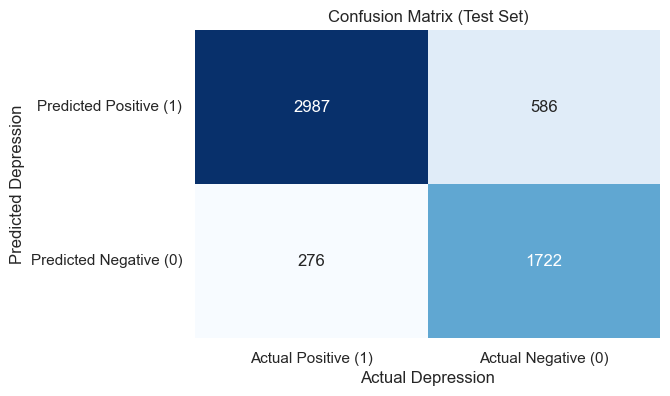


Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.75      0.80      2308
           1       0.84      0.92      0.87      3263

    accuracy                           0.85      5571
   macro avg       0.85      0.83      0.84      5571
weighted avg       0.85      0.85      0.84      5571



In [13]:
#Testing Set Performance

print("\nTesting Set Performance\n")
accuracy_test = accuracy_score(y_test, y_pred_test)
print(f"Accuracy: {accuracy_test:.4f}")

# Plot Confusion Matrix
cm_test = confusion_matrix(y_test, y_pred_test) 

tn, fp, fn, tp = cm_test.ravel()

display_matrix_final = np.array([[tp, fp],
                                 [fn, tn]])

x_labels_final = ["Actual Positive (1)", "Actual Negative (0)"]
y_labels_final = ["Predicted Positive (1)", "Predicted Negative (0)"]

plt.figure(figsize=(6, 4))
sns.heatmap(display_matrix_final,
            annot=True,                
            fmt='d',                   
            cmap='Blues',              
            cbar=False,                
            xticklabels=x_labels_final, 
            yticklabels=y_labels_final) 

plt.xlabel("Actual Depression") 
plt.ylabel("Predicted Depression") 
plt.title("Confusion Matrix (Test Set)") 
plt.yticks(rotation=0)
plt.show()

print("\nClassification Report:")
print(classification_report(y_test, y_pred_test))

In [14]:
# ROC AUC Score 
roc_auc = roc_auc_score(y_test, y_pred_proba_test)
print(f"\nROC AUC Score (Test Set): {roc_auc:.4f}")


ROC AUC Score (Test Set): 0.9223


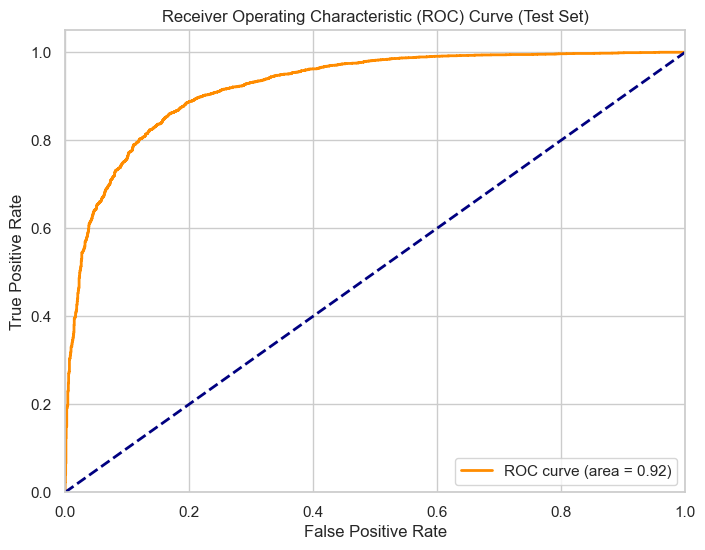

In [15]:
# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba_test)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve (Test Set)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

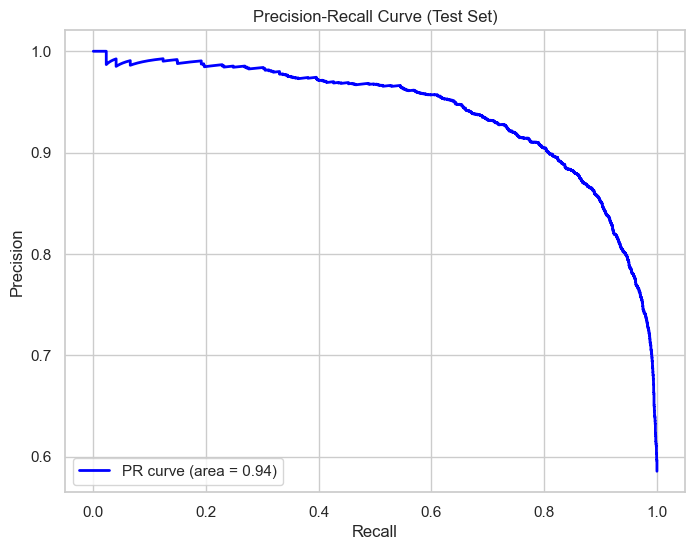

In [16]:
# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba_test)
pr_auc = auc(recall, precision)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Test Set)')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

### Feature Importance

In [17]:
print("\n-Feature Importance")

if hasattr(rfecv, 'feature_importances_'):
    feature_importances = pd.DataFrame({
        'feature': X.columns,
        'importance': rfecv.feature_importances_
    }).sort_values('importance', ascending=False)

    print("Top 20 Feature Importances:")
    print(feature_importances.head(20))

    # Plot top N feature importances
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importances.head(20), palette='viridis')
    plt.title('Top 20 Feature Importances (XGBoost)')
    plt.tight_layout()
    plt.show()
else:
    print("Could not retrieve feature importances from the model.")



-Feature Importance
Could not retrieve feature importances from the model.
